# FACIAL EMOTIONS CLASSIFICATION - RESNET50

#### Dominique Del Valle, Claudio Macher

### IMPORTS

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os

### DATASET PATH

In [9]:
train_path = 'emotion_images/train'
test_path = 'emotion_images/test'
validation_path = 'emotion_images/validation'
image_categories = os.listdir('emotion_images/train')

### PLOT CATEGORIES

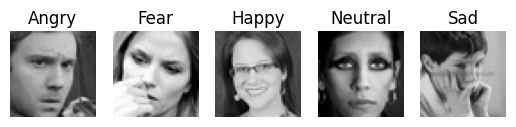

In [10]:
def plot_images(image_categories):

    # Create a figure
    plt.figure(figsize=(10, 10))
    
classes = []

for i, cat in enumerate(image_categories):
    classes.append(cat)

    # Load images for the ith category

    image_path = train_path + '/' + cat
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[0]
    first_image_path = image_path + '/' + first_image_of_folder
    img = tf.keras.utils.load_img(first_image_path)
    img_arr = tf.keras.utils.img_to_array(img)/255.0

    # Create Subplot and plot the images
    plt.subplot(2, 5, i+1)
    plt.imshow(img_arr)
    plt.title(cat)
    plt.axis('off')

plt.show()

In [11]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   shear_range=0.2,
                                   rescale=1./255,
                                   zoom_range=0.2,)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42,
    class_mode="categorical",
    classes=classes)


test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    seed=42,
    shuffle=False,
    batch_size=32,
    class_mode="categorical",
    classes=classes)


val_set = val_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    seed=42,
    shuffle=False,
    batch_size=32,
    class_mode="categorical",
    classes=classes)


Found 19970 images belonging to 5 classes.
Found 4202 images belonging to 5 classes.
Found 4230 images belonging to 5 classes.


In [12]:
from keras.applications.resnet import ResNet50
from keras.models import Model
import keras
from keras import Sequential
from keras.layers import *
from sklearn.metrics import confusion_matrix, classification_report 

### RESNET-50

In [13]:
resnet = ResNet50(include_top=False,
                  weights='imagenet',
                  input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 5)                 501765    
                                                                 
Total params: 24,089,477
Trainable params: 501,765
Non-trainable params: 23,587,712
_________________________________________________________________


#### 5 épocas

In [14]:
resnet_history = model.fit(train_set,epochs=5,validation_data=val_set)

Epoch 1/5
625/625 [==============================] - 1478s 2s/step - loss: 8.5550 - accuracy: 0.2097 - val_loss: 14.1749 - val_accuracy: 0.1596
Epoch 2/5
625/625 [==============================] - 1479s 2s/step - loss: 7.8539 - accuracy: 0.2276 - val_loss: 8.1860 - val_accuracy: 0.2487
Epoch 3/5
625/625 [==============================] - 1474s 2s/step - loss: 7.5638 - accuracy: 0.2623 - val_loss: 3.3336 - val_accuracy: 0.1910
Epoch 4/5
625/625 [==============================] - 1481s 2s/step - loss: 8.9171 - accuracy: 0.2380 - val_loss: 7.1062 - val_accuracy: 0.3111
Epoch 5/5
625/625 [==============================] - 1477s 2s/step - loss: 7.1124 - accuracy: 0.2527 - val_loss: 5.1351 - val_accuracy: 0.1757


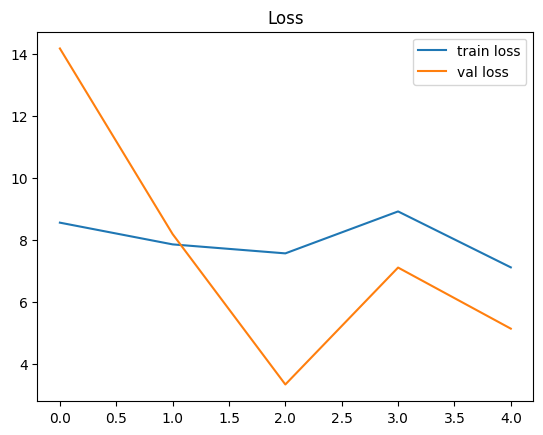

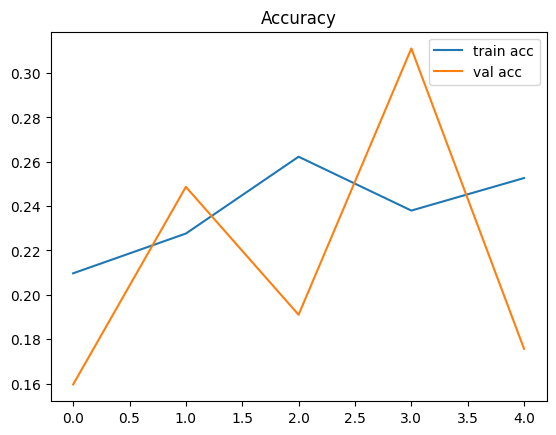

In [15]:
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')
plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')


In [16]:
resnet_auc = model.evaluate(test_set)

132/132 [==============================] - 252s 2s/step - loss: 4.9564 - accuracy: 0.1742


In [18]:
test_pred = model.predict(test_set)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = test_set.labels

132/132 [==============================] - 262s 2s/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

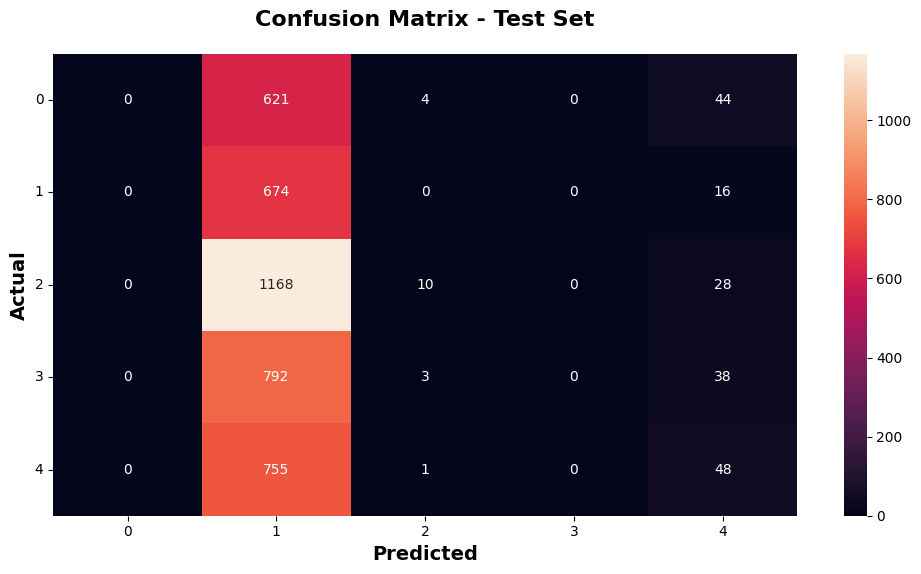

In [19]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
), annot=True,
    fmt="d")
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Confusion Matrix - Test Set', fontsize=16, weight='bold', pad=20)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report 
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       669
           1       0.17      0.98      0.29       690
           2       0.56      0.01      0.02      1206
           3       0.00      0.00      0.00       833
           4       0.28      0.06      0.10       804

    accuracy                           0.17      4202
   macro avg       0.20      0.21      0.08      4202
weighted avg       0.24      0.17      0.07      4202



d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 10 épocas

In [21]:
resnet_history = model.fit(train_set,epochs=10,validation_data=val_set)

Epoch 1/10
625/625 [==============================] - 1516s 2s/step - loss: 7.8203 - accuracy: 0.2510 - val_loss: 4.2157 - val_accuracy: 0.2362
Epoch 2/10
625/625 [==============================] - 1525s 2s/step - loss: 8.9189 - accuracy: 0.2719 - val_loss: 6.9366 - val_accuracy: 0.3158
Epoch 3/10
625/625 [==============================] - 1525s 2s/step - loss: 8.3811 - accuracy: 0.2541 - val_loss: 15.1016 - val_accuracy: 0.2019
Epoch 4/10
625/625 [==============================] - 1530s 2s/step - loss: 9.3084 - accuracy: 0.2493 - val_loss: 19.5233 - val_accuracy: 0.2877
Epoch 5/10
625/625 [==============================] - 1531s 2s/step - loss: 8.0837 - accuracy: 0.2703 - val_loss: 10.8622 - val_accuracy: 0.1612
Epoch 6/10
625/625 [==============================] - 1540s 2s/step - loss: 7.9714 - accuracy: 0.2693 - val_loss: 4.9489 - val_accuracy: 0.3593
Epoch 7/10
625/625 [==============================] - 1539s 2s/step - loss: 7.4236 - accuracy: 0.2654 - val_loss: 5.6906 - val_accura

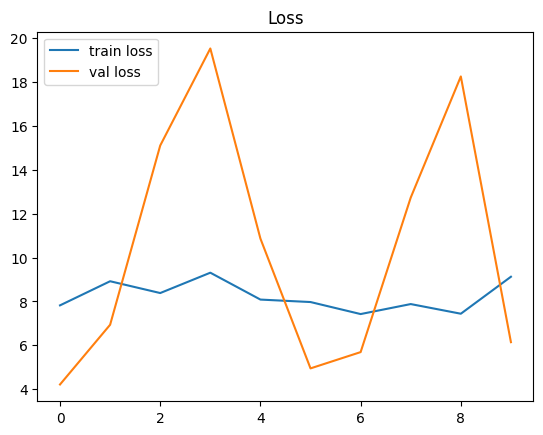

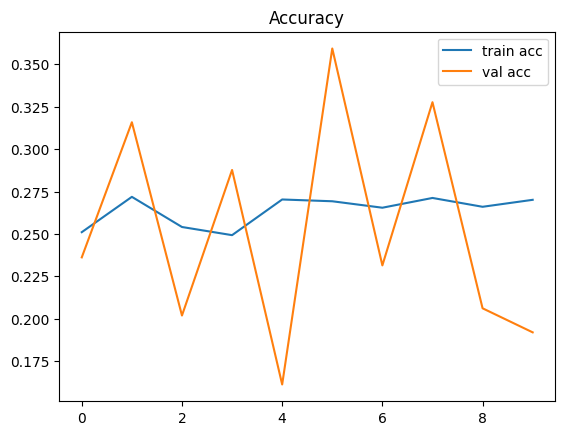

In [22]:
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')
plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [23]:
resnet_auc = model.evaluate(test_set)

132/132 [==============================] - 262s 2s/step - loss: 5.8595 - accuracy: 0.2123


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

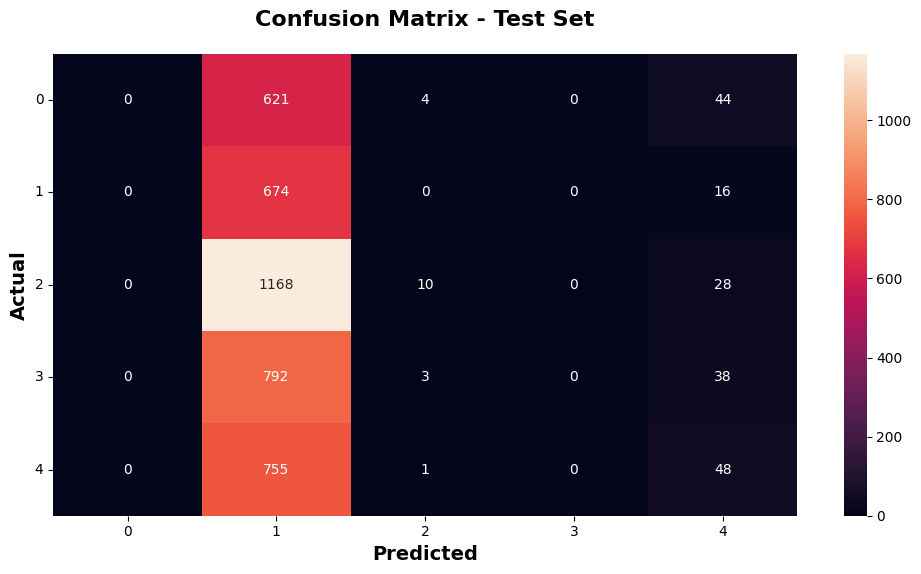

In [24]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
), annot=True,
    fmt="d")
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Confusion Matrix - Test Set', fontsize=16, weight='bold', pad=20)


In [25]:
from sklearn.metrics import confusion_matrix, classification_report 
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       669
           1       0.17      0.98      0.29       690
           2       0.56      0.01      0.02      1206
           3       0.00      0.00      0.00       833
           4       0.28      0.06      0.10       804

    accuracy                           0.17      4202
   macro avg       0.20      0.21      0.08      4202
weighted avg       0.24      0.17      0.07      4202



d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 20 épocas

In [27]:
resnet_history = model.fit(train_set,epochs=20,validation_data=val_set)

Epoch 1/20
 78/625 [==>...........................] - ETA: 19:39 - loss: 7.2236 - accuracy: 0.3053

KeyboardInterrupt: 

In [ ]:
plt.plot(resnet_history.history['loss'], label='train loss')
plt.plot(resnet_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')
plt.plot(resnet_history.history['accuracy'], label='train acc')
plt.plot(resnet_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [ ]:
resnet_auc = model.evaluate(test_set)

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None,
), annot=True,
    fmt="d")
ax.set_xlabel('Predicted', fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Actual', fontsize=14, weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Confusion Matrix - Test Set', fontsize=16, weight='bold', pad=20)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report 
print(classification_report(test_labels, test_pred))